In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from scipy.signal import butter, filtfilt
from numpy.linalg import inv
import warnings
import scienceplots
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import matplotlib.lines as mlines

warnings.filterwarnings("ignore")

plt.style.use(["bmh", "science", "notebook", "grid"])
# Shades of blue
PRIMARY = "#0072b2"
PRIMARY_DARK = "#000080"
# Shades of red
SECONDARY = "#a60628"
SECONDARY_DARK = "#79011B"
# Shades of green
TERCIARY = "#228b22"
TERCIARY_DARK = "#556b2f"
# Shades of yellow
ALTERNATIVE = "#edb230"
ALTERNATIVE_DARK = "#e77728"
# Shades of black
TEXT_COLOR = "#212121"
plt.rc("font", family="Arial")
FONT_SIZE = 19
LABEL_SIZE = 12
VMIN = 6000
VMAX = 17000

plt.rcParams.update(
    {
        "axes.labelsize": LABEL_SIZE,
        "axes.titlesize": FONT_SIZE,
        "xtick.labelsize": LABEL_SIZE,
        "ytick.labelsize": LABEL_SIZE,
        "text.color": TEXT_COLOR,
        "axes.labelcolor": TEXT_COLOR,
        "axes.edgecolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
    }
)

In [3]:
imp_30hz = np.load("Uncompressed/impedance_30hz.npy")
imp_back = np.load("Uncompressed/impedance_background.npy")
ricker_max_likelihood = np.load("Uncompressed/inverted_max_likelihood_ricker.npy")
butter_max_likelihood = np.load("Uncompressed/inverted_max_likelihood_butter.npy")
ricker_sparse_spike = np.load("Uncompressed/inverted_sparse_spike_ricker.npy")
butter_sparse_spike = np.load("Uncompressed/inverted_sparse_spike_butter.npy")

In [4]:
residuo_max_likelihood_ricker = imp_30hz - ricker_max_likelihood
residuo_max_likelihood_butter = imp_30hz - butter_max_likelihood
residuo_sparse_spike_ricker = imp_30hz - ricker_sparse_spike
residuo_sparse_spike_butter = imp_30hz - butter_sparse_spike

In [5]:
# Global variables
# Used in most cases

nx, ny, nz = imp_30hz.shape

# Traço Sísmico

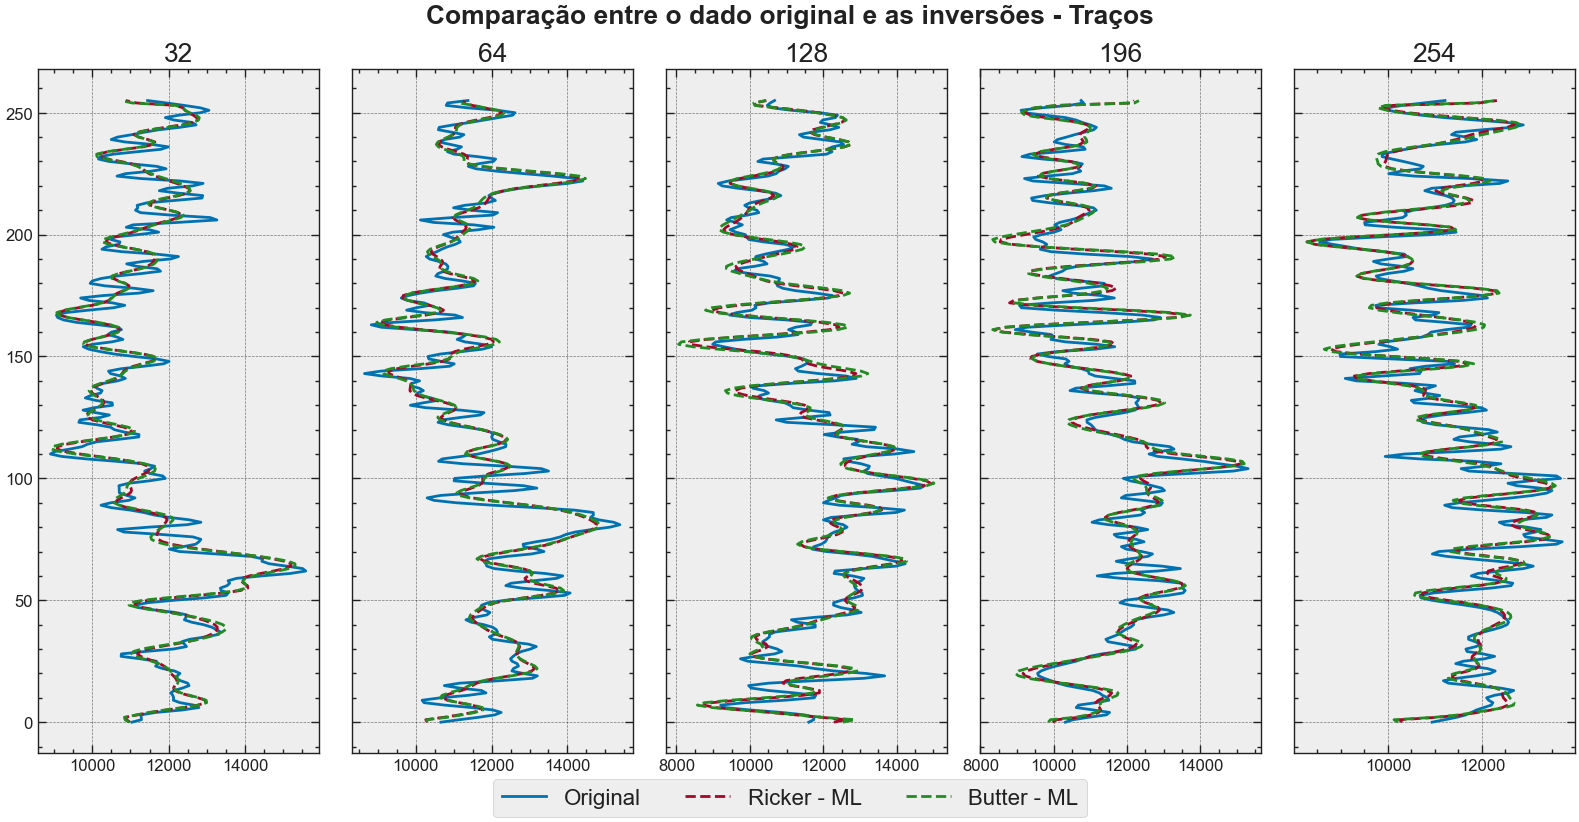

In [6]:
# 32, 64, 128, 196, 256
traco = np.arange(0, 256, 1)
SECTION = 128
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 8))

fig.suptitle("Comparação entre o dado original e as inversões - Traços", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

indices = [32, 64, 128, 196, 254]
for i, ax in enumerate(axs):
    ax.plot(imp_30hz[indices[i], SECTION, :].T, traco, label='Original', color=PRIMARY)
    ax.plot(ricker_max_likelihood[indices[i], SECTION, :].T, traco, "--", label='Ricker - ML', color=SECONDARY)
    ax.plot(butter_max_likelihood[indices[i], SECTION, :].T, traco, "--", label='Butter - ML', color=TERCIARY)
    ax.set_title(f'{indices[i]}')

fig.tight_layout()

# Adiciona uma única legenda para toda a figura
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.show()

# MAPE

## Maximum Likelihood

In [7]:
from tqdm import tqdm

ml_MAPE_ricker_3D = np.zeros_like(ricker_max_likelihood)
ml_MAPE_butter_3D = np.zeros_like(butter_max_likelihood)
ml_MAPE_ricker_2D = np.zeros(nx)
ml_MAPE_butter_2D = np.zeros(nx)

for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces"):
    ml_MAPE_ricker_3D[ix, iy, :] = (
        MAPE(imp_30hz[ix, iy, :], ricker_max_likelihood[ix, iy, :]) * 100
    )
    ml_MAPE_butter_3D[ix, iy, :] = (
        MAPE(imp_30hz[ix, iy, :], butter_max_likelihood[ix, iy, :]) * 100
    )
    if iy == 128:
        ml_MAPE_ricker_2D[ix] = (
            MAPE(imp_30hz[ix, iy, :], ricker_max_likelihood[ix, iy, :]) * 100
        )
        ml_MAPE_butter_2D[ix] = (
            MAPE(imp_30hz[ix, iy, :], butter_max_likelihood[ix, iy, :]) * 100
        )

# MAPE 3D é o MAPE global
# MAPE 2D é o MAPE na linha 128
print(
    f"A média do MAPE Global na inversão Max Likelihood - Ricker é: {np.mean(ml_MAPE_ricker_3D):.2f}%"
)
print(
    f"A média do MAPE Global na inversão Max Likelihood - Butterworth é: {np.mean(ml_MAPE_butter_3D):.2f}%"
)
print("--------------------------------")
print(
    f"A média do MAPE no traço 128 na inversão Max Likelihood - Ricker é: {np.mean(ml_MAPE_ricker_2D):.2f}%"
)
print(
    f"A média do MAPE no traço 128 na inversão Max Likelihood - Butterworth é: {np.mean(ml_MAPE_butter_2D):.2f}%"
)

Processing traces: 65536it [00:12, 5155.63it/s]

A média do MAPE Global na inversão Max Likelihood - Ricker é: 3.50%
A média do MAPE Global na inversão Max Likelihood - Butterworth é: 3.75%
--------------------------------
A média do MAPE no traço 128 na inversão Max Likelihood - Ricker é: 3.78%
A média do MAPE no traço 128 na inversão Max Likelihood - Butterworth é: 4.04%


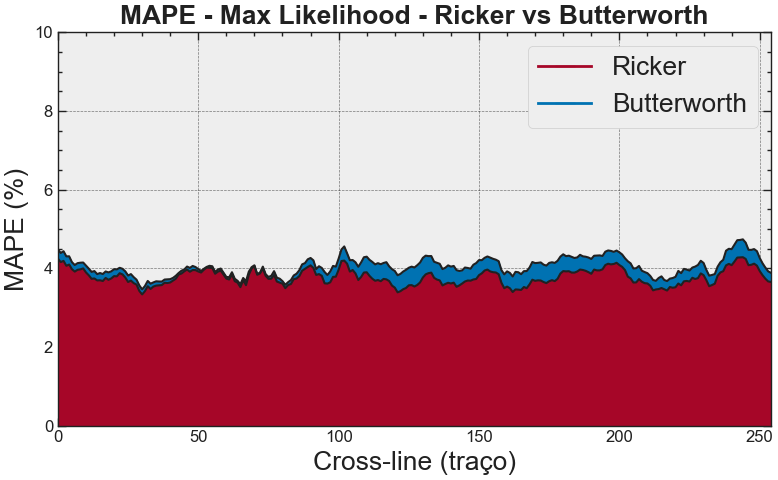

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(
    ml_MAPE_butter_2D,
    "-",
    label="Butterworth",
    ms=2,
    linewidth=1.5,
    color=TEXT_COLOR,
    markeredgecolor="black",
    markeredgewidth=0.5,
)
plt.fill_between(range(len(ml_MAPE_butter_2D)), ml_MAPE_butter_2D, color=PRIMARY)

plt.plot(
    ml_MAPE_ricker_2D,
    "-",
    label="Ricker",
    ms=2,
    linewidth=1.5,
    color=TEXT_COLOR,
    markeredgecolor="black",
    markeredgewidth=0.5,
)
plt.fill_between(range(len(ml_MAPE_ricker_2D)), ml_MAPE_ricker_2D, color=SECONDARY)

# Create custom legend lines
line_ricker = mlines.Line2D(
    [], [], color=SECONDARY, marker="_", markersize=15, label="Ricker"
)
line_butter = mlines.Line2D(
    [], [], color=PRIMARY, marker="_", markersize=15, label="Butterworth"
)

plt.title(
    "MAPE - Max Likelihood - Ricker vs Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
plt.xlabel("Cross-line (traço)", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.ylabel("MAPE (%)", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
#plt.gca().set_aspect('auto')
plt.legend(handles=[line_ricker, line_butter], loc="upper right", fontsize=FONT_SIZE)
plt.ylim(0, 10)
plt.xlim(0, 254)

plt.tight_layout()
# plt.savefig("Figures/stats/mape_ml_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

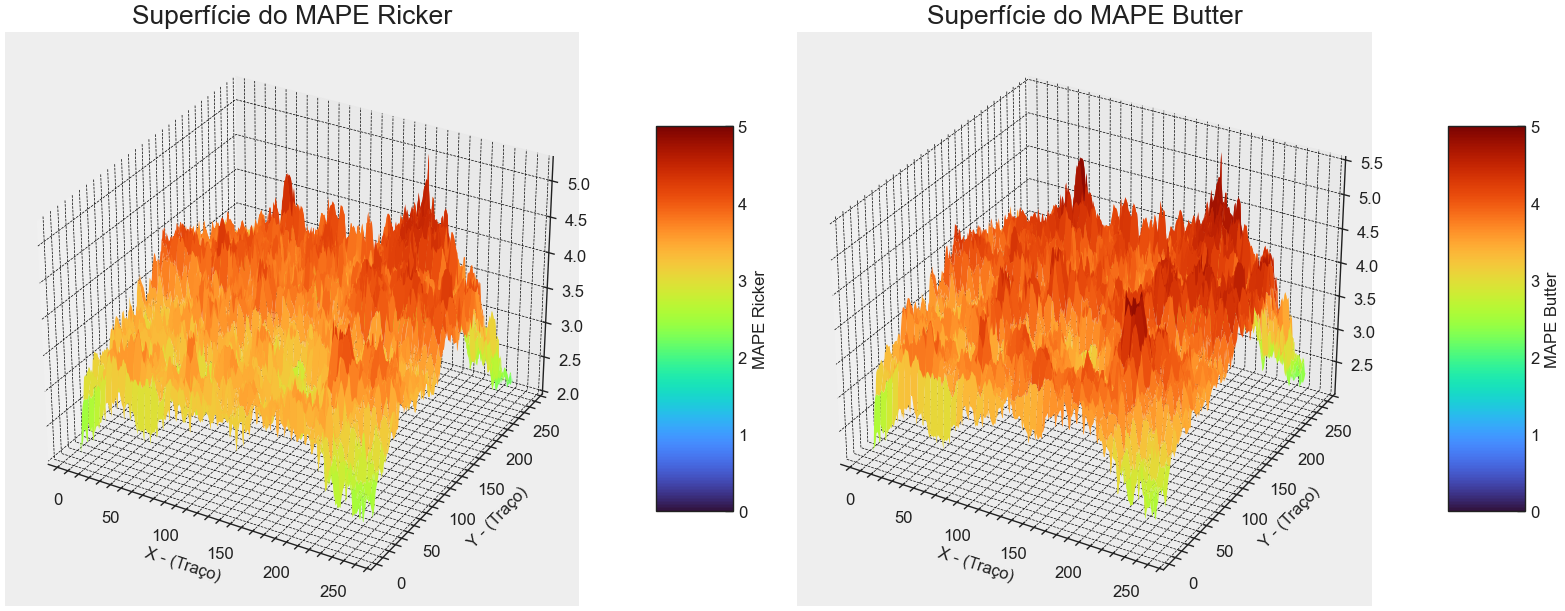

In [9]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(ml_MAPE_ricker_3D.shape[0])
y = np.arange(ml_MAPE_ricker_3D.shape[1])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(16, 8))

vmin = 0
vmax = 5

# Primeiro subplot para ml_MAPE_ricker
ax1 = fig.add_subplot(121, projection="3d")
surf1 = ax1.plot_surface(
    x,
    y,
    ml_MAPE_ricker_3D[:, :, 0].T,
    cmap="turbo",
    edgecolor="none",
    vmin=vmin,
    vmax=vmax,
)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, pad=0.1, label="MAPE Ricker")
ax1.set_title("Superfície do MAPE Ricker")
ax1.set_xlabel("X - (Traço)")
ax1.set_ylabel("Y - (Traço)")

# Segundo subplot para ml_MAPE_butter
ax2 = fig.add_subplot(122, projection="3d")
surf2 = ax2.plot_surface(
    x,
    y,
    ml_MAPE_butter_3D[:, :, 0].T,
    cmap="turbo",
    edgecolor="none",
    vmin=vmin,
    vmax=vmax,
)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, pad=0.1, label="MAPE Butter")
ax2.set_title("Superfície do MAPE Butter")
ax2.set_xlabel("X - (Traço)")
ax2.set_ylabel("Y - (Traço)")

plt.tight_layout()
plt.show()

## Sparse-spike

In [10]:
from tqdm import tqdm

ss_MAPE_ricker_3D = np.zeros_like(ricker_sparse_spike)
ss_MAPE_butter_3D = np.zeros_like(butter_sparse_spike)
ss_MAPE_ricker_2D = np.zeros(nx)
ss_MAPE_butter_2D = np.zeros(nx)

for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces"):
    ss_MAPE_ricker_3D[ix, iy, :] = (
        MAPE(imp_30hz[ix, iy, :], ricker_sparse_spike[ix, iy, :]) * 100
    )
    ss_MAPE_butter_3D[ix, iy, :] = (
        MAPE(imp_30hz[ix, iy, :], butter_sparse_spike[ix, iy, :]) * 100
    )
    if iy == 128:
        ss_MAPE_ricker_2D[ix] = (
            MAPE(imp_30hz[ix, iy, :], ricker_sparse_spike[ix, iy, :]) * 100
        )
        ss_MAPE_butter_2D[ix] = (
            MAPE(imp_30hz[ix, iy, :], butter_sparse_spike[ix, iy, :]) * 100
        )

# MAPE 3D é o MAPE global
# MAPE 2D é o MAPE na linha 128
print(
    f"A média do MAPE Global na inversão Sparse-Spike - Ricker é: {np.mean(ss_MAPE_ricker_3D):.2f}%"
)
print(
    f"A média do MAPE Global na inversão Sparse-Spike - Butterworth é: {np.mean(ss_MAPE_butter_3D):.2f}%"
)
print("--------------------------------")
print(
    f"A média do MAPE no traço 128 na inversão Sparse-Spike - Ricker é: {np.mean(ss_MAPE_ricker_2D):.2f}%"
)
print(
    f"A média do MAPE no traço 128 na inversão Sparse-Spike - Butterworth é: {np.mean(ss_MAPE_butter_2D):.2f}%"
)

Processing traces: 65536it [00:12, 5279.95it/s]


A média do MAPE Global na inversão Sparse-Spike - Ricker é: 4.24%
A média do MAPE Global na inversão Sparse-Spike - Butterworth é: 4.24%
--------------------------------
A média do MAPE no traço 128 na inversão Sparse-Spike - Ricker é: 4.31%
A média do MAPE no traço 128 na inversão Sparse-Spike - Butterworth é: 4.31%


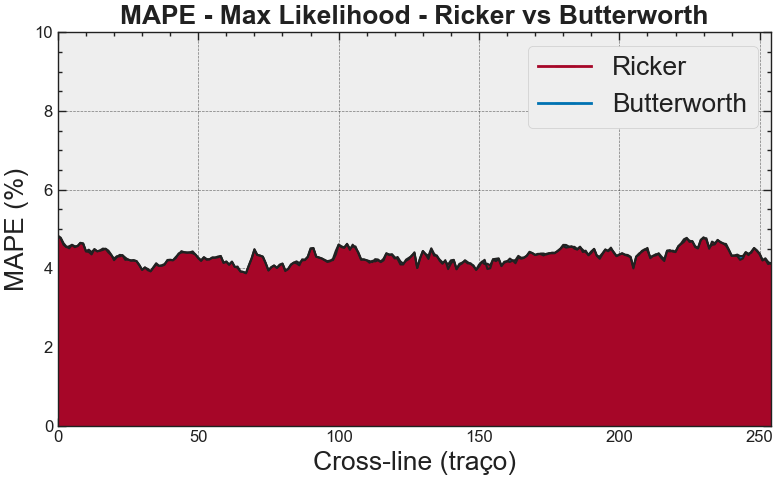

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(
    ss_MAPE_butter_2D,
    "-",
    label="Butterworth",
    ms=2,
    linewidth=1.5,
    color=TEXT_COLOR,
    markeredgecolor="black",
    markeredgewidth=0.5,
)
plt.fill_between(range(len(ss_MAPE_butter_2D)), ss_MAPE_butter_2D, color=PRIMARY)

plt.plot(
    ss_MAPE_ricker_2D,
    "-",
    label="Ricker",
    ms=2,
    linewidth=1.5,
    color=TEXT_COLOR,
    markeredgecolor="black",
    markeredgewidth=0.5,
)
plt.fill_between(range(len(ss_MAPE_ricker_2D)), ss_MAPE_ricker_2D, color=SECONDARY)

# Create custom legend lines
line_ricker = mlines.Line2D(
    [], [], color=SECONDARY, marker="_", markersize=15, label="Ricker"
)
line_butter = mlines.Line2D(
    [], [], color=PRIMARY, marker="_", markersize=15, label="Butterworth"
)

plt.title(
    "MAPE - Max Likelihood - Ricker vs Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
plt.xlabel("Cross-line (traço)", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.ylabel("MAPE (%)", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.legend(handles=[line_ricker, line_butter], loc="upper right", fontsize=FONT_SIZE)
plt.ylim(0, 10)
plt.xlim(0, 254)

plt.tight_layout()
# plt.savefig("Figures/stats/mape_ss_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

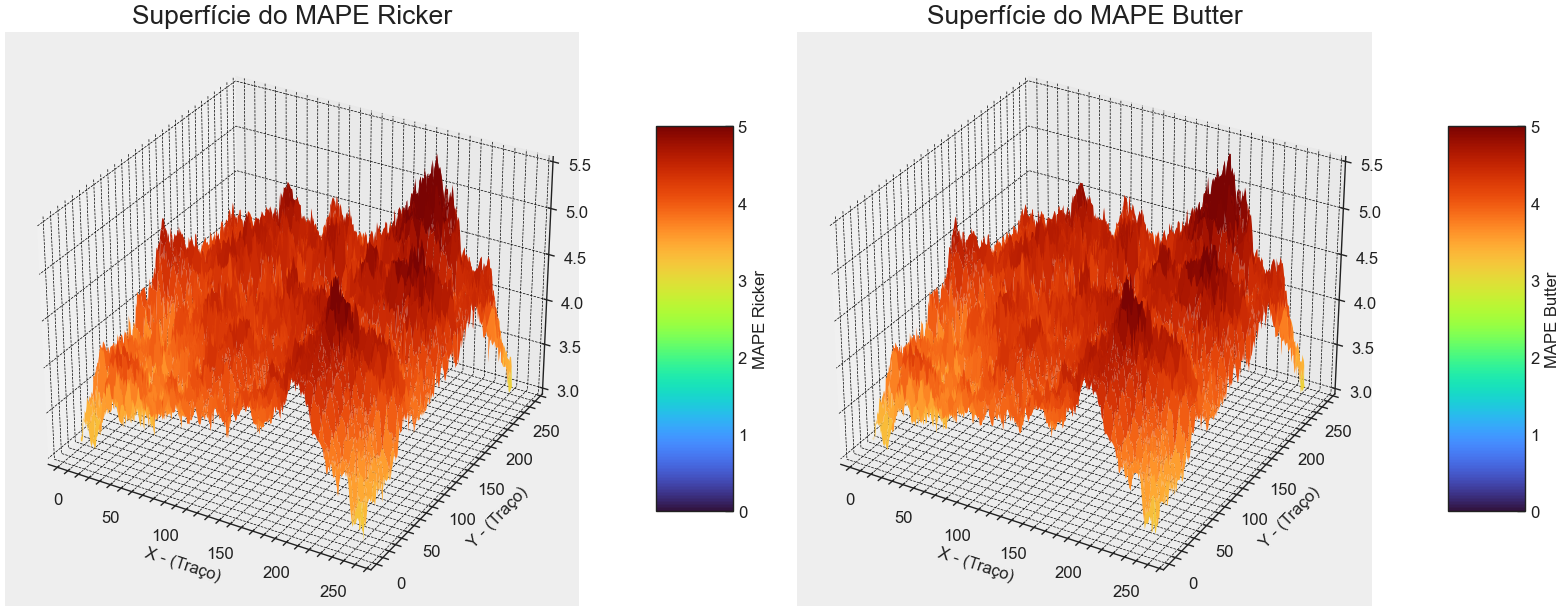

In [12]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(ss_MAPE_ricker_3D.shape[0])
y = np.arange(ss_MAPE_ricker_3D.shape[1])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(16, 8))

vmin = 0
vmax = 5

# Primeiro subplot para ss_MAPE_ricker
ax1 = fig.add_subplot(121, projection="3d")
surf1 = ax1.plot_surface(
    x,
    y,
    ss_MAPE_ricker_3D[:, :, 0].T,
    cmap="turbo",
    edgecolor="none",
    vmin=vmin,
    vmax=vmax,
)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, pad=0.1, label="MAPE Ricker")
ax1.set_title("Superfície do MAPE Ricker")
ax1.set_xlabel("X - (Traço)")
ax1.set_ylabel("Y - (Traço)")

# Segundo subplot para ss_MAPE_butter
ax2 = fig.add_subplot(122, projection="3d")
surf2 = ax2.plot_surface(
    x,
    y,
    ss_MAPE_butter_3D[:, :, 0].T,
    cmap="turbo",
    edgecolor="none",
    vmin=vmin,
    vmax=vmax,
)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, pad=0.1, label="MAPE Butter")
ax2.set_title("Superfície do MAPE Butter")
ax2.set_xlabel("X - (Traço)")
ax2.set_ylabel("Y - (Traço)")

plt.tight_layout()
plt.show()

# Correlação de Pearson

## Max Likelihood

In [13]:
from scipy.stats import pearsonr as pearson

ml_correlation_ricker = pearson(
    imp_30hz.flatten(), ricker_max_likelihood.flatten()
)[0]
ml_correlation_butter = pearson(
    imp_30hz.flatten(), butter_max_likelihood.flatten()
)[0]

print(
    f"ML - A correlação de Pearson global entre o original e a inversão de Ricker é: {ml_correlation_ricker:.2f}"
)
print(
    f"ML - A correlação de Pearson global entre o original e a inversão de Ricker é: {ml_correlation_butter:.2f}"
)

ML - A correlação de Pearson global entre o original e a inversão de Ricker é: 0.91
ML - A correlação de Pearson global entre o original e a inversão de Ricker é: 0.90


In [ ]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 1)

# section = 254
ml_correlation_or = np.zeros(len(values))
ml_correlation_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ml_correlation_or[i] = pearson(
        imp_30hz[value, value, :].flatten(),
        ricker_max_likelihood[value, value, :].flatten(),
    )[0]

    ml_correlation_ob[i] = pearson(
        imp_30hz[value, value, :].flatten(),
        butter_max_likelihood[value, value, :].flatten(),
    )[0]

print(
    f"ML - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Ricker é: {np.mean(ml_correlation_or):.2f}"
)
print(
    f"ML - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Butterworth é: {np.mean(ml_correlation_ob):.2f}"
)

## Sparse-spike

In [ ]:
from scipy import stats

ss_correlation_ricker = pearson(
    imp_30hz.flatten(), ricker_sparse_spike.flatten()
)[0]
ss_correlation_butter = pearson(
    imp_30hz.flatten(), butter_sparse_spike.flatten()
)[0]

print(
    f"SS - A correlação de Pearson global entre o original e a inversão de Ricker é: {ss_correlation_ricker:.2f}"
)
print(
    f"SS - A correlação de Pearson global entre o original e a inversão de Ricker é: {ss_correlation_butter:.2f}"
)

In [ ]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 1)

# section = 254
ss_correlation_or = np.zeros(len(values))
ss_correlation_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ss_correlation_or[i] = pearson(
        imp_30hz[value, value, :].flatten(),
        ricker_sparse_spike[value, value, :].flatten(),
    )[0]

    ss_correlation_ob[i] = pearson(
        imp_30hz[value, value, :].flatten(),
        butter_sparse_spike[value, value, :].flatten(),
    )[0]

print(
    f"SS - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Ricker é: {np.mean(ss_correlation_or):.2f}"
)
print(
    f"SS - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Butterworth é: {np.mean(ss_correlation_ob):.2f}"
)

In [1]:
# Unificação das imagens
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

fig.suptitle("Correlação de Pearson ao longo da Cross-line", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

axs[0].plot(values, ml_correlation_or, "-", label=f"OR: {np.mean(ml_correlation_or):.2f}", lw=2, color=PRIMARY)
axs[0].plot(values, ml_correlation_ob, "-", label=f"OB: {np.mean(ml_correlation_ob):.2f}", lw=2, color=SECONDARY)
axs[0].set_title("Max Likelihood", fontsize=FONT_SIZE, color=TEXT_COLOR)
axs[0].legend(loc="lower right", fontsize=FONT_SIZE)
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].set_ylabel("Coeficiente", fontsize=FONT_SIZE, color=TEXT_COLOR)
axs[0].set_xlabel("X (Seções de cross-line)", fontsize=FONT_SIZE, color=TEXT_COLOR)

axs[1].plot(values, ss_correlation_or, "-", label=f"OR: {np.mean(ss_correlation_or):.2f}", lw=2, color=PRIMARY)
axs[1].plot(values, ss_correlation_ob, "-", label=f"OB: {np.mean(ss_correlation_ob):.2f}", lw=2, color=SECONDARY)
axs[1].set_title("Sparse Spike", fontsize=FONT_SIZE, color=TEXT_COLOR)
axs[1].legend(loc="lower right", fontsize=FONT_SIZE)
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].set_xlabel("X (Seções de cross-line)", fontsize=FONT_SIZE, color=TEXT_COLOR)

plt.ylim(0.60, 1)
plt.tight_layout()
# plt.savefig("")
plt.show()

NameError: name 'plt' is not defined

# Histogramas

# Bland Altman

In [ ]:
def bland_altman_plot(data1, data2):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)

    return mean, diff, mean_diff, std_diff


# ml_bland_altman_butter = bland_altman_plot(imp_30hz.flatten(), butter_max_likelihood.flatten())

In [ ]:
(ml_ricker_mean, ml_ricker_diff, ml_ricker_mean_diff, ml_ricker_std_diff) = (
    bland_altman_plot(
        imp_30hz[0, 0, :].flatten(), ricker_max_likelihood[0, 0, :].flatten()
    )
)

In [ ]:
secoes = [0, 32, 64, 128, 192, 255]

ml_ricker_mean = []
ml_ricker_diff = []
ml_ricker_mean_diff = []
ml_ricker_std_diff = []

for ix in secoes:
    a, b, c, d = bland_altman_plot(
        imp_30hz[ix, ix, :].flatten(), ricker_max_likelihood[ix, ix, :].flatten()
    )
    ml_ricker_mean.append(a)
    ml_ricker_diff.append(b)
    ml_ricker_mean_diff.append(c)
    ml_ricker_std_diff.append(d)

In [ ]:
np.shape(ml_ricker_mean[0])

In [ ]:
def plot_bland_altman(ax, mean, diff, mean_diff, std_diff, title):
    ax.scatter(mean, diff, color=PRIMARY, marker="o")
    ax.axhline(mean_diff, color=SECONDARY, linestyle="--")
    ax.axhline(mean_diff + 1.96 * std_diff, color="gray", linestyle="--")
    ax.axhline(mean_diff - 1.96 * std_diff, color="gray", linestyle="--")
    ax.set_title(title)


# 0, 32, 64, 128, 192, 256
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16, 9))
fig.suptitle(
    "Gráfico de Bland-Altman para a inversão Max Likelihood - Ricker",
    fontsize=FONT_SIZE,
)

sections = [0, 32, 64, 128, 192, 256]
for i, (ax, section) in enumerate(zip(axs.flat, sections)):
    plot_bland_altman(
        ax,
        ml_ricker_mean[i],
        ml_ricker_diff[i],
        ml_ricker_mean_diff[i],
        ml_ricker_std_diff[i],
        f"Seção {section}",
    )

fig.supxlabel("Média dos valores", fontsize=FONT_SIZE)
fig.supylabel("Diferença entre os valores", fontsize=FONT_SIZE)

# Ajuste das margens
plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08)

plt.show()

# Análise de Viés

In [ ]:
bias_ml_ricker = np.mean(imp_30hz.flatten() - ricker_max_likelihood.flatten())
bias_ml_butter = np.mean(imp_30hz.flatten() - butter_max_likelihood.flatten())
print(f"Viés médio: {bias_ml_ricker:.2f}")
print(f"Viés médio: {bias_ml_butter:.2f}")

In [ ]:
bias_ss_ricker = np.mean(imp_30hz.flatten() - ricker_sparse_spike.flatten())
bias_ss_butter = np.mean(imp_30hz.flatten() - butter_sparse_spike.flatten())
print(f"Viés médio: {bias_ss_ricker:.2f}")
print(f"Viés médio: {bias_ss_butter:.2f}")

# R^2

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(imp_30hz.flatten(), ricker_max_likelihood.flatten())
r2_2 = r2_score(imp_30hz.flatten(), butter_max_likelihood.flatten())
print(f"R2 global entre o original e a inversão de Ricker: {r2:.2f}")
print(f"R2 global entre o original e a inversão de Butter: {r2_2:.2f}")

r2_ricker_sparse = r2_score(imp_30hz.flatten(), ricker_sparse_spike.flatten())
r2_butter_sparse = r2_score(imp_30hz.flatten(), butter_sparse_spike.flatten())
print(f"R2 global entre o original e a inversão de Ricker: {r2_ricker_sparse:.2f}")
print(f"R2 global entre o original e a inversão de Butter: {r2_butter_sparse:.2f}")

## ML

In [ ]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 6)

# section = 254
ml_r2_or = np.zeros(len(values))
ml_r2_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ml_r2_or[i] = r2_score(
        imp_30hz[:, value, :].flatten(),
        ricker_max_likelihood[:, value, :].flatten(),
    )

    ml_r2_ob[i] = r2_score(
        imp_30hz[:, value, :].flatten(),
        butter_max_likelihood[:, value, :].flatten(),
    )

print(
    f"ML - O coeficiente de determinação R2 original e a inversão de Ricker é: {np.mean(ml_r2_or):.2f}"
)
print(
    f"ML - O coeficiente de determinação R2 original e a inversão de Butterworth é: {np.mean(ml_r2_ob):.2f}"
)

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(
    values,
    ml_r2_or,
    "o-",
    label=f"R2 - Ricker: {np.mean(ml_r2_or):.2f}",
    lw=2,
    color=PRIMARY,
)
plt.plot(
    values,
    ml_r2_ob,
    "o-",
    label=f"R2 - Butterworth: {np.mean(ml_r2_ob):.2f}",
    lw=2,
    color=SECONDARY,
)


plt.title(
    f"R2 (Coeficiente de Determinação)",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)


plt.legend(loc="lower left", fontsize=FONT_SIZE)
plt.ylim(0.5, 1.00)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.ylabel("Coeficiente", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.xlabel("X (traço)", fontsize=FONT_SIZE, color=TEXT_COLOR)

# plt.savefig("simposio_figs/correlacao_pearson.png", dpi=300, bbox_inches="tight")
plt.show()

## SS

In [ ]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 6)

# section = 254
ml_r2_or = np.zeros(len(values))
ml_r2_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ml_r2_or[i] = r2_score(
        imp_30hz[:, value, :].flatten(),
        ricker_sparse_spike[:, value, :].flatten(),
    )

    ml_r2_ob[i] = r2_score(
        imp_30hz[:, value, :].flatten(),
        butter_sparse_spike[:, value, :].flatten(),
    )

print(
    f"SS - O coeficiente de determinação R2 original e a inversão de Ricker é: {np.mean(ml_r2_or):.2f}"
)
print(
    f"SS - O coeficiente de determinação R2 original e a inversão de Butterworth é: {np.mean(ml_r2_ob):.2f}"
)

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(
    values,
    ml_r2_or,
    "o-",
    label=f"R2 - Ricker: {np.mean(ml_r2_or):.2f}",
    lw=2,
    color=PRIMARY,
)
plt.plot(
    values,
    ml_r2_ob,
    "o-",
    label=f"R2 - Butterworth: {np.mean(ml_r2_ob):.2f}",
    lw=2,
    color=SECONDARY,
)


plt.title(
    f"R2 (Coeficiente de Determinação)",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)


plt.legend(loc="lower left", fontsize=FONT_SIZE)
plt.ylim(0.5, 1.00)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.ylabel("Coeficiente", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.xlabel("X (traço)", fontsize=FONT_SIZE, color=TEXT_COLOR)

# plt.savefig("simposio_figs/correlacao_pearson.png", dpi=300, bbox_inches="tight")
plt.show()